## Problem Definition and Proposed Solution

The primary challenge of this project is achieving high accuracy in face recognition despite variations in facial expressions, lighting, and angles. 

To address this, two machine learning approaches are proposed: **Support Vector Machines (SVMs)** and **Convolutional Neural Networks (CNNs)**. 
These models will be trained and evaluated using the **Labeled Faces in the Wild (LFW)** dataset to compare their effectiveness in handling the complexities of face recognition.


# Import Library

In [45]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, add, Activation, MaxPooling2D, Conv2D, Flatten, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as val
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Import Dataset

In [46]:
from sklearn.datasets import fetch_lfw_people
dataset = fetch_lfw_people(min_faces_per_person=60, resize=0.8, color=True)

# Exploratory data analysis

In [3]:
data_shape = dataset.data.shape
data_shape

(1348, 22500)

In [87]:
print(f"Shape of data: {dataset.images.shape}")

Shape of data: (1348, 100, 75, 3)


In [88]:
print(f"Image shape: {dataset.images[0].shape}")
print(f"Number of images: {dataset.data.shape[0]}")
print(f"Number of classes: {len(np.unique(dataset.target))}")

Image shape: (100, 75, 3)
Number of images: 1348
Number of classes: 8


In [89]:
#Verify the name of the celebrity and the shape of the input image
print(dataset.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


C:\Users\votua\AppData\Local\Temp\ipykernel_12968\856392842.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=images_per_person.index, y=images_per_person.values, palette="viridis")
C:\Users\votua\AppData\Local\Temp\ipykernel_12968\856392842.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha='right')


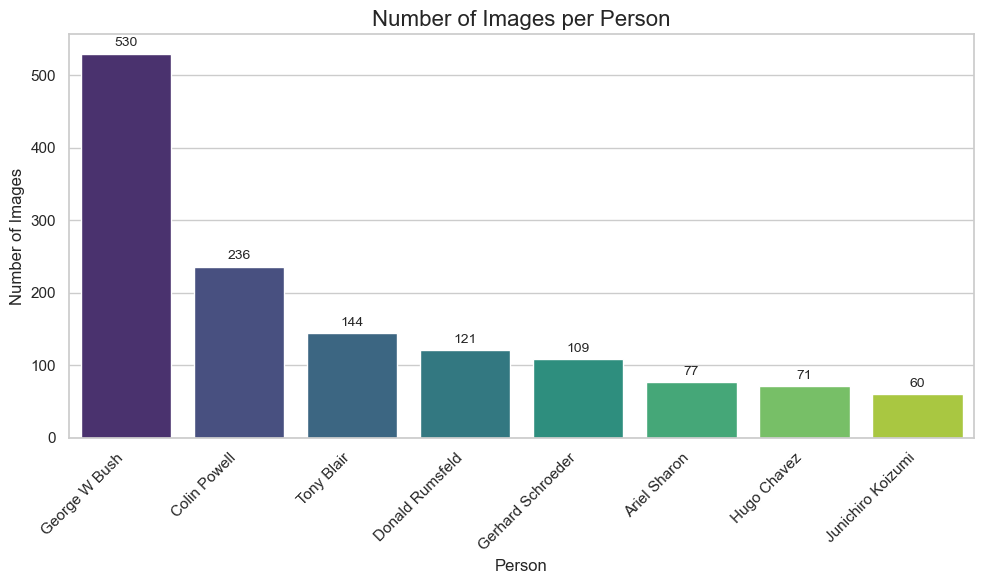

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe for better visual analysis
df = pd.DataFrame({'Person': dataset.target, 'Name': dataset.target_names[dataset.target]})

# Count the number of images per person
images_per_person = df['Name'].value_counts()

# Set seaborn style for a cleaner visual
sns.set(style="whitegrid")

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=images_per_person.index, y=images_per_person.values, palette="viridis")

# Customize the plot
bar_plot.set_title("Number of Images per Person", fontsize=16)
bar_plot.set_ylabel("Number of Images", fontsize=12)
bar_plot.set_xlabel("Person", fontsize=12)
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha='right')

# Add data labels on top of the bars
for i, v in enumerate(images_per_person.values):
    bar_plot.text(i, v + 10, str(v), ha='center', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


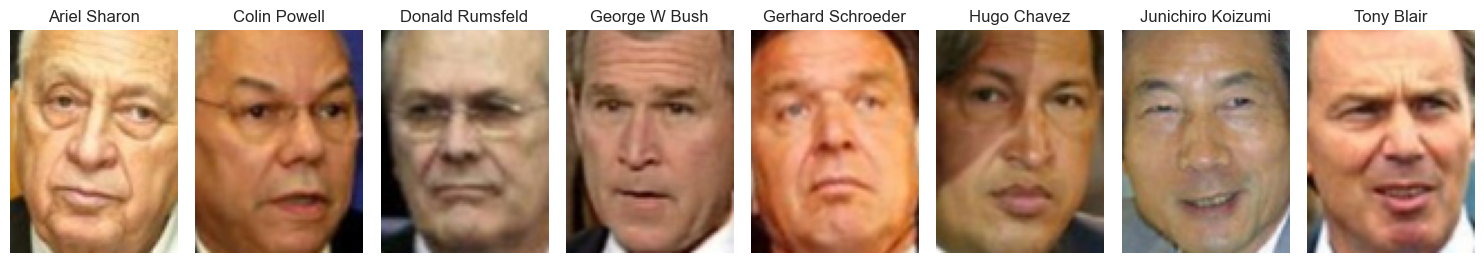

In [8]:
# Plot one sample image for each class in the dataset
fig, axes = plt.subplots(1, 8, figsize=(15, 8)) 

# Fetch unique classes from the dataset
unique_classes = np.unique(dataset.target)

# Loop through and plot one image per class
for i, ax in enumerate(axes.flat[:len(unique_classes)]):
    # Pick the first image of each class
    class_idx = np.where(dataset.target == unique_classes[i])[0][0]
    
    # Plot the image corresponding to the class
    ax.imshow(dataset.images[class_idx], cmap='gray')
    ax.set_title(dataset.target_names[dataset.target[class_idx]])
    ax.axis('off')

plt.tight_layout()
plt.show()



Mean pixel intensity: 0.5087102055549622
Standard deviation of pixel intensity: 0.20899443328380585


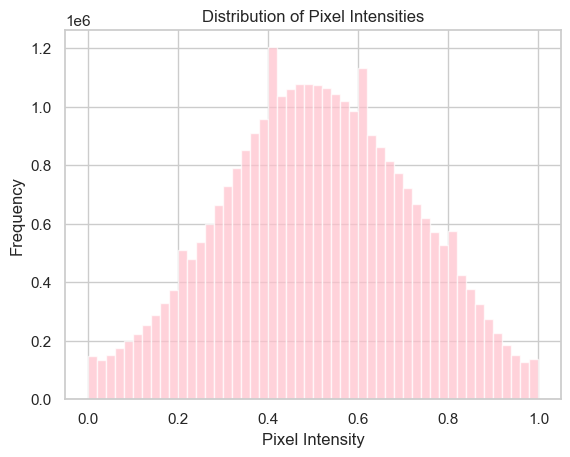

In [9]:
# Flatten the images to analyze pixel intensities
pixel_values = dataset.data

# Check mean and standard deviation of pixel intensities
print(f"Mean pixel intensity: {np.mean(pixel_values)}")
print(f"Standard deviation of pixel intensity: {np.std(pixel_values)}")

# Plot the histogram of pixel intensities
plt.hist(pixel_values.ravel(), bins=50, color='pink', alpha=0.7)
plt.title("Distribution of Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


**Key Observations:**
1. Symmetry Around Mid-Range: The distribution seems to peak around 0.5, indicating that most pixel values are in the medium intensity range. This suggests that the images are generally well-balanced in terms of brightness and contrast.

2. Potential Preprocessing: The relatively even distribution suggests that the pixel intensities are already well-distributed.

# Data Preprocessing

## Reshape Data

In [47]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X = dataset.images
y = dataset.target

# Shuffle the dataset to randomize the order of the samples
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

In [48]:

# Split the features and target variable into 'data' and 'test' sets with an 80-20 ratio
X_data, X_test, y_data, y_test = train_test_split(
    X_shuffled,
    y_shuffled,
    test_size=0.2,    # 20% for the test set
    random_state=42,  
)

# Further split the 'data' set into 'training' and 'validation' sets with an 80-20 ratio
X_train, X_val, y_train, y_val = train_test_split(
    X_data,
    y_data,
    test_size=0.2,    # 20% of the 'data' set for the validation set
    random_state=42,  
)

# Check the shapes of the split data
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 862
Validation set size: 216
Test set size: 270


In [49]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 3)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)

In [50]:
print(X_train.shape)
print(y_train.shape)

(862, 100, 75, 3)
(862,)


## Converting y to One-Hot Encoding:

In [51]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train_onehot: {y_train.shape}")

Shape of X_train: (862, 100, 75, 3)
Shape of y_train_onehot: (862,)


In [52]:
print(f"Unique classes in y_train: {np.unique(y_train)}")

Unique classes in y_train: [0 1 2 3 4 5 6 7]


In [53]:
from tensorflow.keras.utils import to_categorical

num_class = len(np.unique(y))

# One-hot encode the target variable
y_train = to_categorical(y_train, num_classes=num_class)
y_val = to_categorical(y_val, num_classes=num_class)
y_test = to_categorical(y_test, num_classes=num_class)


print(f"Shape of y_train after one-hot encoding: {y_train.shape}")
print(f"Shape of y_val after one-hot encoding: {y_val.shape}")
print(f"Shape of y_test after one-hot encoding: {y_test.shape}")

Shape of y_train after one-hot encoding: (862, 8)
Shape of y_val after one-hot encoding: (216, 8)
Shape of y_test after one-hot encoding: (270, 8)


## Normalizing input

In [54]:
# Normalizing the Data (Scaling pixel values to [0, 1])
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## Data Augmentation

In [137]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for the training set (excluding rescale since it's already done)
train_datagen = ImageDataGenerator(
    rotation_range=20,             # Randomly rotate images by 20 degrees
    width_shift_range=0.2,         # Randomly shift images horizontally by 20%
    height_shift_range=0.2,        # Randomly shift images vertically by 20%
    shear_range=0.2,               # Randomly shear images
    zoom_range=0.2,                # Randomly zoom into images
    horizontal_flip=True           # Randomly flip images horizontally
)

val_datagen = ImageDataGenerator()

# Assuming X_train and y_train are already normalized and one-hot encoded
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Modelling

## CNN

### Build Baseline Model
----

**CNN Architecture:**
- **Conv1**: 32 filters, 3x3 kernel size
- **Conv2**: 64 filters, 3x3 kernel size
- **Pooling1**: 2x2 pooling size
- **Pooling2**: 2x2 pooling size
- **Fully Connected Layer**
- **Dropout**: 0.5 dropout rate
- **Output Layer**:  Softmax for multi-class classification



In [124]:
# Define the CNN model
def base_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer and Conv Layer 1: 32 filters, 5x5 kernel
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    
    # Pooling Layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Layer 2: 64 filters, 5x5 kernel
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    
    # Pooling Layer 2
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layer: 128 units
    model.add(Dense(128, activation='relu'))

    # Dropout to prevent overfitting
    model.add(Dropout(0.5))

    # Output Layer: Softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Assuming input images are of shape (100, 75, 3) and there are 8 output classes
target_names=dataset.target_names
input_shape = (100, 75, 3)
num_classes = 8

# Instantiate and summarize the model
CNN_base_model = base_model(input_shape, num_classes)
CNN_base_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 100, 75, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 50, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 50, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 25, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,952 (14.14 MB)

 Trainable params: 3,706,952 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
pip install tensorboard --upgrade

In [126]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time
import os

# Define a log directory for TensorBoard (each run will have a unique log directory)
experiment_name = "CNN_base_model"
log_dir = os.path.join("logs", "fit", "base_model", time.strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [128]:
# Fit the model and include the TensorBoard and EarlyStopping callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history_base = CNN_base_model.fit(X_train, y_train, epochs=100, batch_size=64, 
                             verbose=1, validation_data=(X_val, y_val,), 
                             callbacks=[tensorboard_callback, early_stopping_callback])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.3932 - loss: 1.8002 - val_accuracy: 0.3611 - val_loss: 1.8643
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.4037 - loss: 1.8064 - val_accuracy: 0.3611 - val_loss: 1.8664
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4024 - loss: 1.8160 - val_accuracy: 0.3611 - val_loss: 1.8511
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4309 - loss: 1.7543 - val_accuracy: 0.3611 - val_loss: 1.8460
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.4148 - loss: 1.7906 - val_accuracy: 0.3611 - val_loss: 1.8576
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4399 - loss: 1.7272 - val_accuracy: 0.3611 - val_loss: 1.8493
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4145 - loss: 1.7801 - val_accuracy: 0.3611 - val_loss: 1.8489
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.4047 - loss: 1.7968 - val_accuracy: 0.

In [131]:
# Make predictions on the validation set using the base_model
base_val_pred = CNN_base_model.predict(X_val)
base_val_pred_labels = np.argmax(base_val_pred, axis=1)  # Convert probabilities to class labels
base_y_val_labels = np.argmax(y_val, axis=1)  # Convert one-hot encoded true labels to class labels

# Calculate accuracy and loss for the validation set
base_val_loss, base_val_accuracy = CNN_base_model.evaluate(X_val, y_val, verbose=1)


# Print validation loss and accuracy
print(f"Validation Loss: {base_val_loss}, Validation Accuracy: {base_val_accuracy}")

# Print classification report (precision, recall, f1-score, and support for each class)
print("\nClassification Report on Validation Set:")
print(classification_report(base_y_val_labels, base_val_pred_labels, target_names=target_names))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8865 - loss: 0.5211
Validation Loss: 0.5976634621620178, Validation Accuracy: 0.8657407164573669

Classification Report on Validation Set:
                   precision    recall  f1-score   support

     Ariel Sharon       0.90      0.69      0.78        13
     Colin Powell       0.82      0.94      0.87        33
  Donald Rumsfeld       0.75      0.71      0.73        17
    George W Bush       0.88      0.99      0.93        78
Gerhard Schroeder       0.84      0.80      0.82        20
      Hugo Chavez       1.00      0.56      0.72        16
Junichiro Koizumi       1.00      1.00      1.00         8
       Tony Blair       0.89      0.81      0.85        31

         accuracy                           0.87       216
        macro avg       0.88      0.81      0.84       216
     weighted avg       0.87      0.87      0.86       216



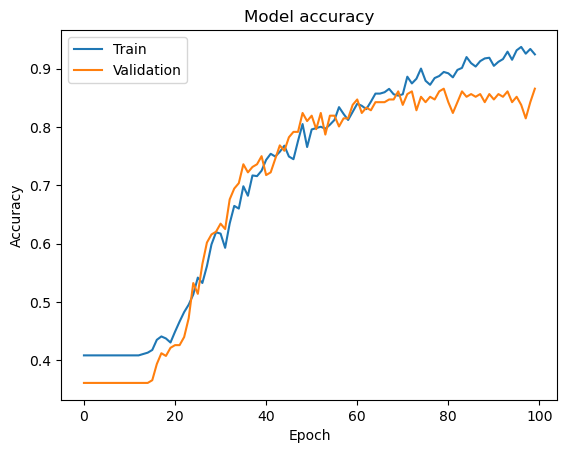

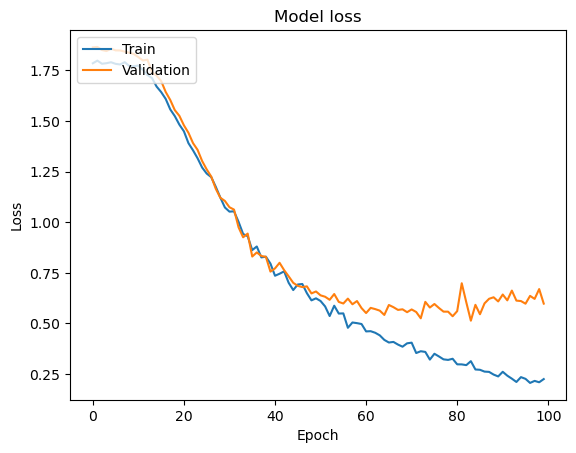

In [132]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_base.history['accuracy'])
plt.plot(history_base.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_base.history['loss'])
plt.plot(history_base.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Fine-tune model

In [141]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define a hypermodel for tuning
def build_model(hp):
    model = Sequential()

    # Tune the number of filters in the first Conv2D layer
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=48, max_value=128, step=16),
        kernel_size=3,
        activation='relu',
        padding='same',
        input_shape=(100, 75, 3)
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Tune the number of filters in the second Conv2D layer
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=96, max_value=256, step=32),
        kernel_size=3,
        activation='relu',
        padding='same'
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the layers
    model.add(Flatten())

    # Tune the number of units in the fully connected Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))

    # Tune the dropout rate
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(8, activation='softmax')) 

    # Tune the learning rate for the Adam optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to be built and evaluated for each trial
    directory='tuner_results4',  # Directory to save the results
    project_name='cnn_tuning4'
)

# Display the search space summary
tuner.search_space_summary()


# Create callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping]
)
# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Trial 10 Complete [00h 07m 22s]
val_accuracy: 0.3611111044883728

Best val_accuracy So Far: 0.5138888955116272
Total elapsed time: 01h 21m 47s
Best hyperparameters: {'conv_1_filters': 48, 'conv_2_filters': 160, 'dense_units': 256, 'dropout': 0.30000000000000004, 'learning_rate': 0.00021802168303237048}


In [142]:
# Build the model with the best hyperparameters
CNN_best_model = tuner.hypermodel.build(best_hps)
CNN_best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 100, 75, 48)    │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 37, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 37, 160)    │        69,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 18, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 72000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    18,432,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,504,936 (70.59 MB)

 Trainable params: 18,504,936 (70.59 MB)

 Non-trainable params: 0 (0.00 B)

In [193]:
# Define a log directory for TensorBoard (each run will have a unique log directory)
experiment_name = "CNN_best_model"
log_dir = os.path.join("logs", "fit", "best_model", time.strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit the model and include the TensorBoard and EarlyStopping callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history_CNN_best_model = CNN_best_model.fit(X_train, y_train, epochs=100, batch_size=64, 
                             verbose=1, validation_data=(X_val, y_val), 
                             callbacks=[tensorboard_callback, early_stopping_callback])

# Evaluate the best model on the validation or test set
val_loss, val_acc = CNN_best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.9987 - loss: 0.0125 - val_accuracy: 0.8380 - val_loss: 0.9923
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.9948 - loss: 0.0161 - val_accuracy: 0.8241 - val_loss: 0.9816
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.9931 - loss: 0.0278 - val_accuracy: 0.8380 - val_loss: 0.9118
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.9984 - loss: 0.0121 - val_accuracy: 0.8472 - val_loss: 0.9583
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.8333 - val_loss: 0.9541
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 0.9969 - loss: 0.0089 - val_accuracy: 0.8426 - val_loss: 0.9162
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - accuracy: 0.9993 - loss: 0.0103 - val_accuracy: 0.8380 - val_loss: 0.9458
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.9978 - loss: 0.0129 - val_accu

In [201]:
%load_ext tensorboard
%tensorboard --logdir logs
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 45232), started 0:02:11 ago. (Use '!kill 45232' to kill it.)

## SVM

### Build base model

In [152]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Flatten the images from 4D (batch_size, height, width, channels) to 2D (batch_size, height * width * channels)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Ensure the labels are 1D (single-label format, not one-hot)
y_train_flat = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
y_val_flat = np.argmax(y_val, axis=1) if len(y_val.shape) > 1 else y_val
y_test_flat = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Apply PCA to reduce dimensionality of the feature vectors
pca = PCA(n_components=100)  

# Fit PCA on the training data first
X_train_pca = pca.fit_transform(X_train_flat)

# Transform validation and test data using the fitted PCA model
X_val_pca = pca.transform(X_val_flat)
X_test_pca = pca.transform(X_test_flat)

# Standardize the features (important for SVM)
scaler = StandardScaler()

# Fit the scaler on the training PCA data
X_train_scaled = scaler.fit_transform(X_train_pca)

# Transform the validation and test data using the fitted scaler
X_val_scaled = scaler.transform(X_val_pca)
X_test_scaled = scaler.transform(X_test_pca)

In [153]:
svm = SVC(class_weight='balanced', random_state=42, kernel='sigmoid')
svm.fit(X_train_scaled, y_train_flat)

# Predict and evaluate on the validation set
y_val_pred = svm.predict(X_val_scaled)
print("Validation Set Classification Report:")
print(classification_report(y_val_flat, y_val_pred))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.73        13
           1       0.78      0.88      0.83        33
           2       0.67      0.71      0.69        17
           3       0.97      0.83      0.90        78
           4       0.64      0.80      0.71        20
           5       0.67      0.75      0.71        16
           6       0.80      1.00      0.89         8
           7       0.83      0.65      0.73        31

    accuracy                           0.80       216
   macro avg       0.75      0.81      0.77       216
weighted avg       0.82      0.80      0.80       216



### Tuning model 

In [186]:
from sklearn.model_selection import GridSearchCV

# Perform hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],        # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  
    'gamma': ['scale', 'auto'],           
}

# Initialize SVM with GridSearchCV
svm_grid = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, refit=True, verbose=3, cv=3)
svm_grid.fit(X_train_scaled, y_train_flat)

# Print the best parameters found by GridSearchCV
print(f"Best Parameters: {svm_grid.best_params_}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.764 total time=   0.0s
[CV 2/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.774 total time=   0.0s
[CV 3/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.787 total time=   0.0s
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.045 total time=   0.0s
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.160 total time=   0.0s
[CV 3/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.052 total time=   0.0s
[CV 1/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.410 total time=   0.0s
[CV 2/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.408 total time=   0.0s
[CV 3/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.167 total time=   0.0s
[CV 1/3] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.378 total time=   0.0s
[CV 2/3] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.352 total time=   0.0s
[CV 3/3] END C=0.1, gamma=scale, kernel=sigmoid;

In [187]:
# Get the best parameters and the best SVM model found by GridSearchCV
best_params = svm_grid.best_params_
best_svm = svm_grid.best_estimator_

# Print the best parameters found by GridSearchCV
print(f"Best Parameters: {best_params}")

# Make predictions on the validation set using the best model
y_val_pred = best_svm.predict(X_val_scaled)
print("Validation Set Classification Report:")
print(classification_report(y_val_flat, y_val_pred))

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.67      0.94      0.78        33
           2       0.87      0.76      0.81        17
           3       0.85      0.92      0.88        78
           4       0.79      0.75      0.77        20
           5       1.00      0.62      0.77        16
           6       1.00      0.88      0.93         8
           7       0.88      0.68      0.76        31

    accuracy                           0.83       216
   macro avg       0.88      0.79      0.82       216
weighted avg       0.85      0.83      0.83       216



# Model Evaluation

## On Valdiation Test

In [188]:
# Dictionary containing your models
models_SVM = {
    'SVM_base_model': svm,
    'SVM_best_model': best_svm,
}

models_CNN = {
    'CNN_base_model': CNN_base_model,
    'CNN_best_model': CNN_best_model
}

In [189]:
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model
import numpy as np

# Dictionary to store the performance results
val_performance = {}

# Function to evaluate CNN models
def evaluate_modelCNN_on_val(model, model_name):
    # Make predictions on the validation set
    val_pred = model.predict(X_val)

    # Convert predicted probabilities to class labels
    val_pred_labels = np.argmax(val_pred, axis=1)

    # Convert one-hot encoded true labels to class labels
    y_val_labels = np.argmax(y_val, axis=1)

    # Calculate accuracy and loss for the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)

    # Store performance in the dictionary
    val_performance[model_name] = {
        'Validation Accuracy': val_accuracy,
        'Validation Loss': val_loss
    }

    # Print classification report (precision, recall, f1-score)
    print(f"\nModel: {model_name}")
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}\n")
    print("Classification Report:")
    print(classification_report(y_val_labels, val_pred_labels, target_names=target_names))

# Function to evaluate SVM models
def evaluate_modelSVM_on_val(model, model_name):
    # SVM directly predicts the class labels, no need for argmax
    val_pred_labels = model.predict(X_val_scaled)  # Use the PCA-transformed version of X_val

    # y_val_flat contains the true class labels for SVM evaluation
    y_val_labels = y_val_flat  # For SVM, we use flat labels, no need to one-hot encode

    # Calculate accuracy for the validation set
    val_accuracy = accuracy_score(y_val_labels, val_pred_labels)

    # Store performance in the dictionary (no loss for SVM, just accuracy)
    val_performance[model_name] = {
        'Validation Accuracy': val_accuracy,
        'Validation Loss': 'N/A'  # Loss does not apply for SVM
    }

    # Print classification report (precision, recall, f1-score)
    print(f"\nModel: {model_name}")
    print(f"Validation Accuracy: {val_accuracy}\n")
    print("Classification Report:")
    print(classification_report(y_val_labels, val_pred_labels, target_names=target_names))



In [190]:
# Evaluate all SVM models on the validation set
for model_name, model in models_SVM.items():
    evaluate_modelSVM_on_val(model, model_name)

# Evaluate all CNN models on the validation set
for model_name, model in models_CNN.items():
    evaluate_modelCNN_on_val(model, model_name)

# Optionally: Print the collected performance results
print("\nValidation Performance Summary:")

for model_name, performance in val_performance.items():
    print(f"{model_name}: Accuracy = {performance['Validation Accuracy']}, Loss = {performance['Validation Loss']}")

# Display test performance for all models
val_performance_df = pd.DataFrame.from_dict(val_performance, orient='index').reset_index()
val_performance_df.rename(columns={'index': 'Model', 'Validation Accuracy': 'Accuracy', 'Validation Loss': 'Loss'}, inplace=True)
print(val_performance_df)


Model: SVM_base_model
Validation Accuracy: 0.8009259259259259

Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.85      0.73        13
     Colin Powell       0.78      0.88      0.83        33
  Donald Rumsfeld       0.67      0.71      0.69        17
    George W Bush       0.97      0.83      0.90        78
Gerhard Schroeder       0.64      0.80      0.71        20
      Hugo Chavez       0.67      0.75      0.71        16
Junichiro Koizumi       0.80      1.00      0.89         8
       Tony Blair       0.83      0.65      0.73        31

         accuracy                           0.80       216
        macro avg       0.75      0.81      0.77       216
     weighted avg       0.82      0.80      0.80       216


Model: SVM_best_model
Validation Accuracy: 0.8287037037037037

Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.77      0.87       

## On Test Set

In [191]:
# Dictionary to store the performance results
test_performance = {}

# Function to evaluate CNN models on the test set
def evaluate_modelCNN_on_test(model, model_name):
    # Make predictions on the test set
    test_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels
    test_pred_labels = np.argmax(test_pred, axis=1)

    # Convert one-hot encoded true labels to class labels
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy and loss for the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

    # Store performance in the dictionary
    test_performance[model_name] = {
        'Test Accuracy': test_accuracy,
        'Test Loss': test_loss
    }

    # Print classification report (precision, recall, f1-score)
    print(f"\nModel: {model_name}")
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n")
    print("Classification Report:")
    print(classification_report(y_test_labels, test_pred_labels, target_names=target_names))

# Function to evaluate SVM models on the test set
def evaluate_modelSVM_on_test(model, model_name):
    # SVM directly predicts the class labels, no need for argmax
    test_pred_labels = model.predict(X_test_scaled)  # Use the PCA-transformed version of X_test

    # y_test_flat contains the true class labels for SVM evaluation
    y_test_labels = y_test_flat  # For SVM, we use flat labels, no need to one-hot encode

    # Calculate accuracy for the test set
    test_accuracy = accuracy_score(y_test_labels, test_pred_labels)

    # Store performance in the dictionary (no loss for SVM, just accuracy)
    test_performance[model_name] = {
        'Test Accuracy': test_accuracy,
        'Test Loss': 'N/A'  # Loss does not apply for SVM
    }

    # Print classification report (precision, recall, f1-score)
    print(f"\nModel: {model_name}")
    print(f"Test Accuracy: {test_accuracy}\n")
    print("Classification Report:")
    print(classification_report(y_test_labels, test_pred_labels, target_names=target_names))

In [192]:
# Evaluate all SVM models on the test set
for model_name, model in models_SVM.items():
    evaluate_modelSVM_on_test(model, model_name)

# Evaluate all CNN models on the test set
for model_name, model in models_CNN.items():
    evaluate_modelCNN_on_test(model, model_name)

# Optionally: Print the collected performance results
print("\nTest Performance Summary:")

for model_name, performance in test_performance.items():
    print(f"{model_name}: Accuracy = {performance['Test Accuracy']}, Loss = {performance['Test Loss']}")

# Display test performance for all models
test_performance_df = pd.DataFrame.from_dict(test_performance, orient='index').reset_index()
test_performance_df.rename(columns={'index': 'Model', 'Test Accuracy': 'Accuracy', 'Test Loss': 'Loss'}, inplace=True)
print(test_performance_df)



Model: SVM_base_model
Test Accuracy: 0.8185185185185185

Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.71      0.65        17
     Colin Powell       0.85      0.84      0.85        63
  Donald Rumsfeld       0.55      0.65      0.59        17
    George W Bush       0.98      0.90      0.94       100
Gerhard Schroeder       0.72      0.72      0.72        25
      Hugo Chavez       0.62      0.73      0.67        11
Junichiro Koizumi       0.75      0.75      0.75        12
       Tony Blair       0.77      0.80      0.78        25

         accuracy                           0.82       270
        macro avg       0.73      0.76      0.74       270
     weighted avg       0.83      0.82      0.82       270


Model: SVM_best_model
Test Accuracy: 0.8407407407407408

Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.65      0.79        17
     Col

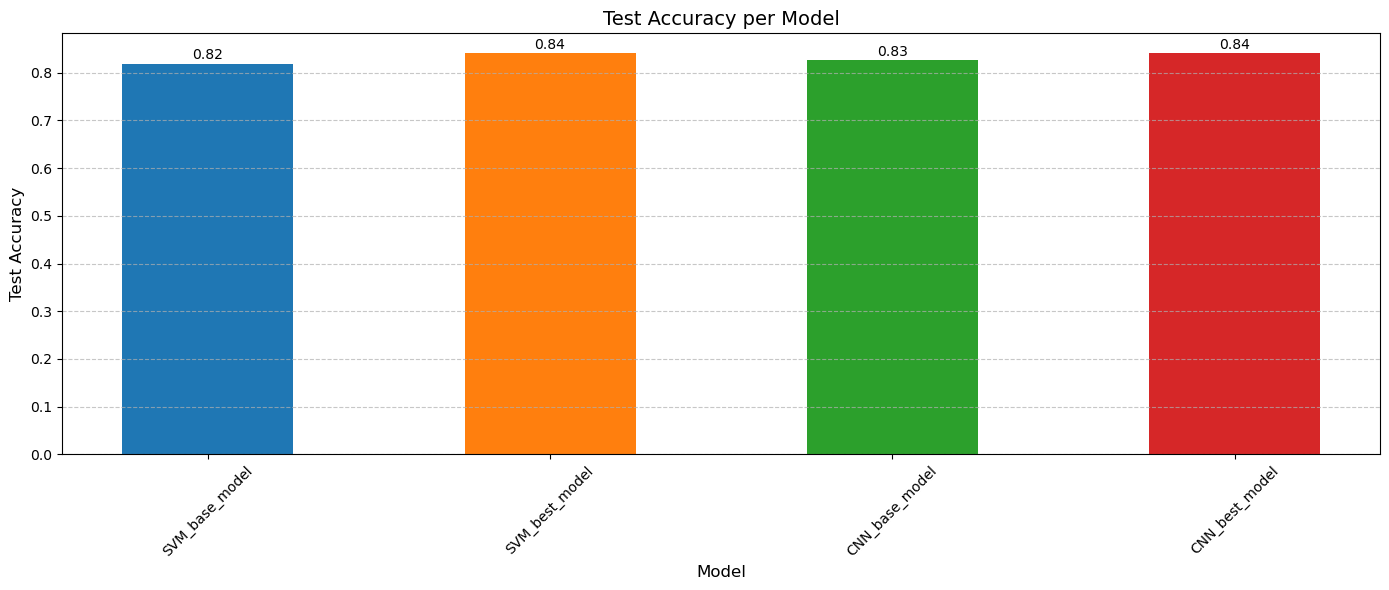

In [198]:
import matplotlib.pyplot as plt

# Convert the 'Model' column to strings for better plotting
test_performance_df['Model'] = test_performance_df['Model'].astype(str)

# Plot the Test Accuracy
fig, ax = plt.subplots(figsize=(14, 6))

# Set colors for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Customize as needed

# Bar chart for Test Accuracy
ax.bar(test_performance_df['Model'], test_performance_df['Accuracy'], color=colors, width=0.5)
ax.set_title('Test Accuracy per Model', fontsize=14)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Annotate bars with Accuracy values
for i, v in enumerate(test_performance_df['Accuracy']):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=10)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


After training and tuning both the **SVM** and **CNN** models, we compared their performance using various metrics, including accuracy, precision, recall, and F1-score.

**1. Overall Accuracy**
Both the **SVM_best_model** and **CNN_best_model** achieved a test accuracy of **84%**, indicating that both models are highly effective at face recognition tasks when properly tuned. However, accuracy alone does not fully capture the strengths and weaknesses of each model.

**2. Precision vs. Recall**
- **SVM_best_model**: Demonstrated stronger **precision**, particularly in certain classes, such as **Ariel Sharon** and **Junichiro Koizumi**, where precision reached **100%**. This makes the SVM model ideal for scenarios where minimizing false positives is critical, such as in secure access systems.
  
- **CNN_best_model**: Excelled in **recall**, meaning it performed better in capturing true positives for certain key classes, such as **Colin Powell** and **George W. Bush**. This makes CNN a better choice for tasks like surveillance, where missing a detection could be more harmful than a false positive.

**3. F1-Score**
- The **SVM_best_model** had a marginally higher **macro average F1-score** of **0.80**, compared to **0.78** for the CNN. This suggests that SVM provided a more balanced trade-off between precision and recall across all classes.

**4. Model Stability and Loss**
While the **CNN_best_model** performed better in terms of recall, it had a higher test loss (**0.937**) compared to the SVM model. This indicates that the CNN model may need further tuning or improvements to reduce overfitting or instability in some cases.

# Conclusion
Both models perform well, but the choice between **SVM** and **CNN** should depend on the specific needs of the task:
- **SVM** is preferred for applications requiring high precision, such as secure access systems.
- **CNN** is better suited for applications that prioritize recall, such as surveillance and detection tasks.